# Walkthrough: Data Collection, Data Processing, and Forecast Modeling

<br>

# Description

This notebook is meant to serve as a walkthrough for the creation an an Energy Demand Forecasting Pipeline. It details how to use the Python modules from this repository to obtain a dataset, process it, and use that dataset to fit a probabilistic energy demand forecasting model. There is an additional notebook included in this repository for evaluating the resulting forecasting model. 

In the following cell, we import all necessary libraries and project modules.

In [1]:
# for development
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import itertools
import warnings
import random
import pickle as pkl
from IPython.display import Image
from copy import deepcopy
import yaml

# exporting plotly figures to html not working correctly
import plotly.io as pio
pio.renderers.default='notebook'

# import custom module
import get_data as gd
import preprocessing as pp
import model_definitions as md

# ignore certain types of warnings
warnings.simplefilter("ignore", DeprecationWarning)

### Saving New Results

The following boolean variable determines whether new data should be loaded from the project's data sources, and whether each of the different components of the pipeline defined in this notebook should update the datasets and figures saved in the repository. This variable should be set to True if downloading a new dataset or creating a new instance of the pipeline from the beginning. It should be set to False if one wants to use the datasets and figures already present in the repository.

In [2]:
new_results = True
# new_results = False

# define the name of the directory within the repository where datasets and figures will be saved
saved_data_directory = "Saved"

# Loading The Data

The first component of this project works to download and compile data from the U.S. Energy Information Agency (EIA), the U.S. National Oceanic and Atmospheric Agency (NOAA), and the U.S. Bereua of Labor Statistics (BLS). This data includes hourly residential energy demand (in MWH) in New York City, along with monthly energy prices, hourly weather-related data from the Central Park station in New York, and monthly economic indicators for New York City. 

The Python module "get_data.py" contains all of the functionality to retrieve and compile this data. The functions within this Python module can be called individually or as a sequence by simply running the module as a script and providing the Python executable with a few arguments, including start date, end date, and an api key. Functions within the module look for an api key in the local directory by default, but I include one here for simplicity. Care should be taken not to share this key unless necessary as it could become deactivated if overused.

In the following cell, I run the "get_data.py" module and obtain a dataset in the local directory called "preliminary.csv".

In [3]:
if new_results: 
    start = "2018-06-19" 
    end = "2024-05-23"
    with open("Configuration Files/api_keys.yml", "r") as file:
        eia_api_key = yaml.safe_load(file)["eia"]

    # run python script to load data and save to Datasets/prelim.csv
    %run get_data.py {start} {end} {eia_api_key}

Requesting energy demand data from EIA over 11 requests
The start time provided is out of bounds. Updating it to the earliest available date of 2018-06-19T05.
Requesting energy price data from EIA
Requesting Weather Data from NOAA
Requesting data from Bereau of Labor Statistics
All data loaded successfully. Saving preliminary dataset to Saved/Datasets/preliminary.csv
Preliminary dataset saved.


### Preliminary Dataset Summary

To see that the python module has run successfully, I can load the dataset and display a summary of its characteristics.

In [4]:
# display summary of dataset
preliminary_data = pd.read_csv(r"{}/Datasets/preliminary.csv".format(saved_data_directory), index_col=0)
desciptions = preliminary_data.describe().round(2)
cols_per_table = 6
for n in range(0,int(np.ceil(desciptions.shape[1]/cols_per_table))):
    display(desciptions.iloc[:,n*cols_per_table : (n*cols_per_table)+cols_per_table])

,Energy Demand (MWH),HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyStationPressure
count,51955.00,50511.00,50531.00,47618.00,50511.00,50321.00
mean,5677.47,42.39,56.54,0.01,62.11,29.88
std,1213.17,19.05,16.77,0.05,19.60,0.23
min,0.00,-17.00,2.00,0.00,7.00,28.71
25%,4794.00,27.00,43.00,0.00,47.00,29.73
50%,5515.00,43.00,56.00,0.00,61.00,29.88
75%,6238.00,59.00,71.00,0.00,78.00,30.03
max,11069.00,79.00,95.00,3.47,100.00,30.59


,HourlyWetBulbTemperature,HourlyWindSpeed,Energy Price (cents/KWH),CPI-U,Unemployment Rate,Unemployment Level
count,50284.00,43093.00,49962.00,51426.00,51426.00,51426.00
mean,49.89,5.06,19.99,296.88,7.01,288110.53
std,15.56,18.98,2.05,18.68,3.94,155186.56
min,0.00,0.00,16.85,273.84,3.30,141889.00
25%,37.00,3.00,18.43,279.82,4.40,185743.00
50%,50.00,5.00,19.37,290.99,5.30,215670.00
75%,64.00,7.00,21.71,314.98,8.70,354780.00
max,81.00,2237.00,24.23,331.27,21.60,837338.00


,Employment Level,Labor Force Level,Employment Population Ratio,Labor Force Participation,Civilian Noninstitutional Population,Payroll Employment
count,51426.00,51426.00,51426.00,51426.00,51426.00,51426.00
mean,3860209.22,4148319.74,55.73,59.89,6928682.62,4479.67
std,234790.65,100409.14,3.53,1.64,153319.78,257.22
min,3045001.00,3703849.00,42.80,52.00,6724877.00,3748.60
25%,3712722.00,4089452.00,54.20,59.60,6774961.00,4287.10
50%,3921604.00,4130506.00,57.30,60.00,6900182.00,4590.80
75%,4064390.00,4246840.00,57.80,60.60,7106427.00,4661.90
max,4137830.00,4318409.00,59.70,62.60,7119864.00,4756.70


<br>

### Reducing the Dataset

The dataset contains 18 variables, not including its datetime index. Many of these variables are highly correlated with each other and simalarly correlated with the dependent variable of interest, *Energy Demand (MWH)*. In order to simplify the rest of this walkthrough a bit (and reduce computation times), I will select a subset of the variables and use only those throughout the rest of the pipeline. I have not yet conducted a thorough analysis of the impacts from including and excluding different variables from the dataset on the predictive performance of the final forecasting model.

In [5]:
variables_considered = ["Energy Demand (MWH)", "HourlyDryBulbTemperature", "HourlyDewPointTemperature", "HourlyWetBulbTemperature",
    "HourlyStationPressure", "HourlyPrecipitation", "HourlyWindSpeed", "Energy Price (cents/KWH)", 
    "Civilian Noninstitutional Population", "Labor Force Participation", "CPI-U"]
preliminary_dataset = preliminary_data[variables_considered]

# preliminary_dataset = preliminary_data # using all variables

<br>

# Data Processing and Cleaning

The second component of this project is a processing pipeline which works to clean the preliminary dataset by transforming select numerical variables to categorical ones, by identifying outliers using moving average estimation, and by imputing values for those outliers and other missing values using Prophet forecasting models and interpolation. All of this functionality, along with methods to create exploratory data analysis visualizations for a web application, are contained within the *PreprocessingPipeline* class defined in the "preprocessing.py" Python module. This module can be used by creating an instance of the class and calling *process_data* as shown below.

<br>

The argument *saved_directory_name* specifies the name of a directory that will be created in the current working directory. Having a local directory to save files to is a necessary part of the project currently, as it allows one to save the processed dataset, forecasting models, and visuals that will be used later by the graphical user interface for the application. The argument *produce_eda_plots* determines whether visualizations are created and saved that help describe the exploratory data analysis which was conducted to better understand the dataset.

<br>

In [6]:
# instantiate processing class
processor = pp.PreprocessingPipeline(saved_directory_name=saved_data_directory, produce_eda_plots=True, save_datasets=True)

In [7]:
if not new_results:
    clean_data = pd.read_csv(r"{}/Datasets/clean_training.csv".format(saved_data_directory), index_col=0)
    clean_data.index = pd.to_datetime(clean_data.index)
else:
    # run processing pipeline, generating eda visuals along the way
    warnings.filterwarnings('ignore', category=UserWarning) # prevents warnings from Seaborn library
    clean_data, holdout_data = processor.process_dataset(preliminary_dataset=preliminary_dataset, split_into_train_holdout=True, train=True)
    clean_data.index = pd.to_datetime(clean_data.index)
    clean_data.loc[:,"HourlyPrecipitation"] = clean_data["HourlyPrecipitation"].replace({np.nan:"None"})
    warnings.resetwarnings()

Interpolating for variable Energy Demand (MWH)
Interpolating for variable HourlyDryBulbTemperature
Interpolating for variable HourlyDewPointTemperature
Interpolating for variable HourlyWetBulbTemperature
Interpolating for variable HourlyStationPressure
Interpolating for variable HourlyWindSpeed
Interpolating for variable Energy Price (cents/KWH)
Interpolating for variable Civilian Noninstitutional Population
Interpolating for variable Labor Force Participation
Interpolating for variable CPI-U
Interpolating for variable HourlyPrecipitation


### Saving the processing pipeline object

If one is going to apply the processing method utilized above to new or unseen data, it is necessary that we save the object and all of its attributes for later use. The processing pipeline contains scalars and models used to normalize and impute missing values for the training data. Saving the pipeline with these attributes helps to ensure that the exact same processing methodology will be applied to unseen data.

In [8]:
# save the ProcessingPipeline object for using on new/evaluation data
if new_results:
    with open(r"{}/Models/processor.pkl".format(saved_data_directory), "wb") as file:
        pkl.dump(processor, file)

# Instantiating and Tuning the Forecasting Model

The third component of the project pipeline focuses on creating a probabilistic forecasting model. A *Forecaster* class has been defined in the "model_definitions.py" module. This class contains methods that can be used to fit a probablisitic forecasting model to the clean time series dataset derived previously and use it to make predictions. It also contains some hyperparameter tuning functionality. In the following code cell, we create an instance of this *Forecaster* class.

In [12]:
model = md.Forecaster(short_term_horizon=24)

<br>

The *Forecaster* class combines a fourier series-based Prophet model with a vector autoregressive (VAR) model and a long short-term memory network. Each of these models has been defined to produce probabilistic forecasts, which include both a MAP point forecast and an estimate of forecast error's variance. Additional details about how the models are able to do this is included in the documentation of the *Forecaster* class, but in simple terms, one pair of Prophet and VAR models are trained to predict the value of the dependent variable, and then another pair is trained to predict the variance of the first model's errors. Both pairs of models are fit using an MSE loss function. The LSTM is trained to predict a pre-defined number of time-steps ahead using an MSE loss function, and dropout layers are used to approximate the behavior of a Bayesian network for the purpose of making probabilistic predictions. When combined, the point forecasts and variance forecasts describe a normally distributed prediction interval from which confidence intervals can be estimated. The *Forecaster* class contains a number of hyperparameters that can be tuned using the *tune_hyperparamters* method, as shown below. This method currently conducts a grid-search style hyperparamter tuning algorithm and should be used whenever the training data has undergone significant changes or updates.

In [12]:
pvhrf = r"Datasets/PV_hyperparameter_results.csv" # Prophet-Var hyperparameter results filename

# determine whether existing hyperparameter results are overwritten when the cell below is run.
reset_pv_hyperparameter_values = True # comment this out to overwrite hyperparameter results
# reset_pv_hyperparameter_values = False # comment this out to avoid overwriting hyperparameter results

The following code conducts a grid-search style hyperparameter tuning process for the Prophet-VAR model. This will take a while to run. It is not necessary to run this unless the hyperparameters defined below it have not been updated in a long time.

In [ ]:
# define hyperparameter sets
pv_hyperparameter_sets = dict(changepoint_prior_scale=[0.5, 0.001], seasonality_prior_scale=[0.5, 0.01], 
    point_var_lags=[10], minimum_error_prediction=[100, 500, None], error_trend=[1e-2, 1e-1, 1, 10])

# load in previous hyperparameter evaluations 
if not reset_pv_hyperparameter_values:
    pv_hyperparameter_results = pd.read_csv(r"{}/{}".format(saved_data_directory, pvhrf))

# create new dataframe of hyperparameter values
keys = pv_hyperparameter_sets.keys()
values = pv_hyperparameter_sets.values()
combinations = itertools.product(*values)
results = pd.DataFrame(columns=keys, data=combinations)
results.loc[:,["MSE", "WMSE"]] = [np.nan, np.nan]

# combine previous results with new results
if not reset_pv_hyperparameter_values:
    results = pd.concat([pv_hyperparameter_results, results], axis=0)
    results = results.sort_values(by=["MSE", "WMSE"], na_position="last")
    results = results.drop_duplicates(subset=results.columns.drop(["MSE", "WMSE"]))

results = results[results["MSE"].isna()]

# run grid-search hyperparameter tuning using 5-fold rolling cross-validation
results = model.tune_hyperparameters(clean_training_data=clean_data, 
    dependent_variable="Energy Demand (MWH)", pv_hyperparameter_sets=results,
    lstm_hyperparameter_sets=None, num_cv_folds=5, verbose=True)[0]

pv_hyperparameter_results = pd.concat([pv_hyperparameter_results, results], axis=0)

# save hyperparameter results 
pv_hyperparameter_results = pv_hyperparameter_results[pv_hyperparameter_results["MSE"].notna()]
pv_hyperparameter_results.to_csv(r"{}/{}".format(saved_data_directory, pvhrf), index=False)

In [9]:
best_pv_hyperparameters = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'point_var_lags': 10, 'minimum_error_prediction': 100, 'error_trend': 100}

The following code conducts a grid-search style hyperparameter tuning process for the LSTM model. This will take a while to run. It is not necessary to run this unless the hyperparameters defined below it have not been updated in a long time.

In [18]:
lhrf = r"Datasets/LSTM_hyperparameter_results.csv" # LSTM hyperparameter results filename

# determine whether existing hyperparameter results are overwritten when the cell below is run.
# reset_lstm_hyperparameter_values = True # comment this out to overwrite hyperparameter results
reset_lstm_hyperparameter_values = False # comment this out to avoid overwriting hyperparameter results

In [ ]:
# define hyperparameter sets
lstm_hyperparameter_sets = dict(lr=[0.001, 0.0005, 0.0001], batch_size=[100],
    hidden_size=[16,32,64], num_layers=[1,2], dropout=[0.01,0.1,0.2,0.3], sequence_length=[3*7*24],
    max_epochs=[100])

# load in previous hyperparameter evaluations 
if not reset_lstm_hyperparameter_values:
    lstm_hyperparameter_results = pd.read_csv(r"{}/{}".format(saved_data_directory, pvhrf))

# create new dataframe of hyperparameter values
keys = lstm_hyperparameter_sets.keys()
values = lstm_hyperparameter_sets.values()
combinations = itertools.product(*values)
results = pd.DataFrame(columns=keys, data=combinations)
results.loc[:,["MSE", "WMSE"]] = [np.nan, np.nan]

# combine previous results with new results
if not reset_lstm_hyperparameter_values:
    results = pd.concat([lstm_hyperparameter_results, results], axis=0)
    results = results.sort_values(by=["MSE", "WMSE"], na_position="last")
    results = results.drop_duplicates(subset=results.columns.drop([["MSE", "WMSE"]]))

lstm_hyperparameter_sets = results[results["MSE"].isna()]

# run grid-search hyperparameter tuning using 5-fold rolling cross-validation
lstm_hyperparameter_results = model.tune_hyperparameters(clean_training_data=clean_data, 
    dependent_variable="Energy Demand (MWH)", pv_hyperparameter_sets=None,
    lstm_hyperparameter_sets=lstm_hyperparameter_sets, num_cv_folds=5, verbose=True)[0]

# save hyperparameter results 
lstm_hyperparameter_results = lstm_hyperparameter_results[lstm_hyperparameter_results["MSE"].notna()]
lstm_hyperparameter_results.to_csv(r"{}/{}".format(saved_data_directory, lhrf), index=False)

In [10]:
best_lstm_hyperparameters = {"batch_size":100, "lr":0.0005, "dropout":0.1, "num_layers":1, "hidden_size":32, "sequence_length":24*7*3, "max_epochs":100}

<br>

The *tune_hyperparameters* function relies on the *cross_validate* function which runs a K-folds rolling window cross validation function. This method is currently defined to calculate the average MSE and average weighted MSE metrics over the K folds. Below, we show an example of the function run on the optimal hyperparameter sets identified above.

### Cross Validate with Best Set of Hyperparameters

In [16]:
warnings.filterwarnings('ignore') # ignores a deprecation warning TODO

# cross validate Prophet-VAR long-term forecasts
print("Cross Validating Prophet-VAR long-term forecasts.")
pv_mse, pv_wmse = model.cross_validate_pv(num_folds=5, clean_training_data=clean_data, 
    dependent_variable="Energy Demand (MWH)", pv_hyperparameters=best_pv_hyperparameters, verbose_validation=True)

# cross validate lstm short-term forecasts
print("\nCross Validating LSTM short-term forecasts.")
lstm_mse, lstm_wmse = model.cross_validate_lstm(num_folds=5, clean_training_data=clean_data, 
    dependent_variable="Energy Demand (MWH)", lstm_hyperparameters=best_lstm_hyperparameters, verbose_validation=True, 
    verbose_training=False)

Cross Validating Prophet-VAR long-term forecasts.
Training Prophet-VAR model for CV Fold 1 out of 5.
Validation Fold 1 out of 5. MSE: 3038470.113, WMSE: 2955383.835.
Training Prophet-VAR model for CV Fold 2 out of 5.
Validation Fold 2 out of 5. MSE: 321783.852, WMSE: 311723.681.
Training Prophet-VAR model for CV Fold 3 out of 5.
Validation Fold 3 out of 5. MSE: 432028.182, WMSE: 353739.554.
Training Prophet-VAR model for CV Fold 4 out of 5.
Validation Fold 4 out of 5. MSE: 293119.307, WMSE: 252742.081.
Training Prophet-VAR model for CV Fold 5 out of 5.
Validation Fold 5 out of 5. MSE: 359026.364, WMSE: 260690.353.

Cross Validating LSTM short-term forecasts.
Training LSTM for CV Fold 1 out of 5.
Validation Fold 1 out of 5. MSE: 2568145.188, WMSE: 2568065.087.
Training LSTM for CV Fold 2 out of 5.


KeyboardInterrupt: 

<br>

### Fit the Final Model

To actually fit the model with a specific set of hyperparameters, one can use the *fit* function. This will trigger several other methods to run that fit the necessary Prophet and VAR models on the given training data using the provided set of hyperparameters. The dependent variable needs to be specified and is set to be *Energy Demand (MWH)* in the example below.

In [22]:
warnings.filterwarnings('ignore')
model.fit(clean_training_data=clean_data, dependent_variable="Energy Demand (MWH)", 
    hyperparameters=best_pv_hyperparameters | best_lstm_hyperparameters, lstm_device="cuda", verbose=True)

# save best model to repository as pickle file
model_path = r"Saved/Models/forecaster.pkl"
with open(model_path, "wb") as file:
    pkl.dump(model, file)

Fitting Prophet-VAR Model
Fitting LSTM Model
Average Parameter Absolute Value: 0.08881
Average Gradient Absolute Value: 0.61296
Epoch 1, Training Loss: 34.61040215412204
Epoch 1, Validation Loss: 34.59197637882639
Average Parameter Absolute Value: 0.09133
Average Gradient Absolute Value: 1.13927
Epoch 2, Training Loss: 28.840917880014835
Epoch 2, Validation Loss: 29.044427476030716
Average Parameter Absolute Value: 0.09294
Average Gradient Absolute Value: 1.05339
Epoch 3, Training Loss: 21.487048485296235
Epoch 3, Validation Loss: 18.11864361864455
Average Parameter Absolute Value: 0.09494
Average Gradient Absolute Value: 1.08717
Epoch 4, Training Loss: 13.969595875957316
Epoch 4, Validation Loss: 10.606971223303612
Average Parameter Absolute Value: 0.09661
Average Gradient Absolute Value: 0.85059
Epoch 5, Training Loss: 10.934099560447162
Epoch 5, Validation Loss: 8.142737941539034
Average Parameter Absolute Value: 0.09816
Average Gradient Absolute Value: 0.51391
Epoch 6, Training Los

In [32]:
display(clean_data)

,Energy Demand (MWH),HourlyDryBulbTemperature,HourlyDewPointTemperature,HourlyWetBulbTemperature,HourlyStationPressure,HourlyPrecipitation,HourlyWindSpeed,Energy Price (cents/KWH),Civilian Noninstitutional Population,Labor Force Participation,CPI-U
2018-06-19 05:00:00,7221.0,78.0,72.0,74.0,29.62,None,6.000000,19.28,7105823.0,60.1,274.170
2018-06-19 06:00:00,6911.0,79.0,70.0,73.0,29.63,None,6.000000,19.28,7105823.0,60.1,274.170
2018-06-19 07:00:00,6691.0,81.0,69.0,73.0,29.63,None,3.543315,19.28,7105823.0,60.1,274.170
2018-06-19 08:00:00,6582.0,82.0,67.0,72.0,29.63,None,3.796411,19.28,7105823.0,60.1,274.170
2018-06-19 09:00:00,6600.0,81.0,69.0,73.0,29.65,None,7.000000,19.28,7105823.0,60.1,274.170
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-19 07:00:00,3882.0,55.0,50.0,52.0,30.03,None,0.000000,22.06,6742143.0,61.7,325.288
2023-10-19 08:00:00,3816.0,58.0,46.0,52.0,30.03,None,4.061850,22.06,6742143.0,61.7,325.288
2023-10-19 09:00:00,3842.0,59.0,45.0,52.0,30.02,None,6.000000,22.06,6742143.0,61.7,325.288
2023-10-19 10:00:00,4052.0,61.0,43.0,52.0,30.01,None,6.000000,22.06,6742143.0,61.7,325.288


In [43]:
import gc
gc.collect()
predictions = model.short_term_predict(clean_data.iloc[-5000:], lstm_sequence_length=24*3*7, expected_output_size=5000-model.short_term_horizon-24*3*7+1)

['Energy Demand (MWH)', 'HourlyDryBulbTemperature', 'HourlyDewPointTemperature', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'Energy Price (cents/KWH)', 'Civilian Noninstitutional Population', 'Labor Force Participation', 'CPI-U', 'HourlyPrecipitation_Light Rain', 'HourlyPrecipitation_Medium Rain', 'HourlyPrecipitation_None']
['Energy Demand (MWH)', 'HourlyDryBulbTemperature', 'HourlyDewPointTemperature', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'Energy Price (cents/KWH)', 'Civilian Noninstitutional Population', 'Labor Force Participation', 'CPI-U', 'HourlyPrecipitation_Light Rain', 'HourlyPrecipitation_Medium Rain', 'HourlyPrecipitation_None']


In [44]:
display(predictions)

,Point Forecast,Variance Forecast
2023-04-16 03:00:00,6309.599609,276445.471067
2023-04-16 04:00:00,6028.137695,276398.433287
2023-04-16 05:00:00,5683.871582,276383.435766
2023-04-16 06:00:00,5360.494141,276303.602062
2023-04-16 07:00:00,5109.943848,276317.404099
...,...,...
2023-10-19 07:00:00,4225.183105,276232.580413
2023-10-19 08:00:00,4163.885742,276301.348273
2023-10-19 09:00:00,4168.651367,276246.628370
2023-10-19 10:00:00,4273.354492,276259.552037


In [48]:
trace1 = go.Scatter(x=predictions.index, y=predictions["Point Forecast"])
x = clean_data["Energy Demand (MWH)"].iloc[-5000:]
trace2 = go.Scatter(x=x.index, y=x.values)
fig = go.Figure([trace1, trace2])
fig.show()

diffs = predictions["Point Forecast"] - x
diffs = diffs[diffs.notna()]
mse = (diffs**2).sum()/diffs.shape[0]
display(mse)

344423.99898621946

<br>

In the figure above, the predicted point forecasts have been colored in blue while the actual forecasts have been colored in red. The green line denotes the upper bounds of the 95% confidence interval while the purple line represents the lower bounds of the 95% CI. The figure does encapsulate a lot of data points, so it is nice to be able to zoom in on certain sections in order to better visualize the relationships between each of the lines.

<br>

### Measure Final Model Performance

Below, we evaluate the predicted forecasts by calculating the mean square error (MSE) and weighted MSE of their residuals from the actual energy demand values. We also define a baseline yearly moving average and evaluate its predictive performance. A Wilcoxon Signed Rank test is used to test the null hypothesis that our forecasting pipeline has the same median residual as the baseline model. Rejecting this null hypothesis, on the condition that our forecasting model has a low MSE than the baseline model, will provide statistical evidence that our forecasting model is significantly more accurate than the baseline moving average.

Create report describing model performance

<br>

As can be seen from the results above, our forecasting pipeline does appear to be significantly more accurate than a baseline yearly moving average. Additionally, since the weighted MSE for the forecasting pipeline is much lower than the regular MSE, it seems clear that the variance forecasts are able to improve the reliability of the forecasting model.

<br>

# Testing EDA Visuals

The previous section validated that the forecasting pipeline is functioning as expected and performing better than a simple baseline model. Now, we want to test that the EDA portions of the processing component correctly generated all of the visuals that are going to be needed for the GUI portion of the project. Note that the tests below will not work if the *PreProcessingPipeline* was defined with *produce_eda_plots* set to False.

### Check that all outlier plots were created

The code below checks that there are pkl files for all of the numerical variables in the processed dataset. All of these variables should have had outlier identification conducted and therefore should have a *plotly* figure saved that will be shown in the GUI. Once it has checked that all of the expected pkl files are present, it selects a random file and displays the figure within.

In [33]:
# check that all numerical variables have outlier identification plots
for variable in clean_data.select_dtypes("number").columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Plotly Figures/Outlier Detection"
    filepath = r"{}/{}.pkl".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The outlier plot for {} is missing".format(variable))

# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in 
    clean_data.select_dtypes("number")])
filepath = r"{}/{}.pkl".format(directory, variable)
with open(filepath, 'rb') as file:
    figure = pkl.load(file)
figure.show()

<br>

### Load Random Distribution Plot

The following code conducts a similar check as above but for distribution plots for every variable included in the processing component of the pipeline.

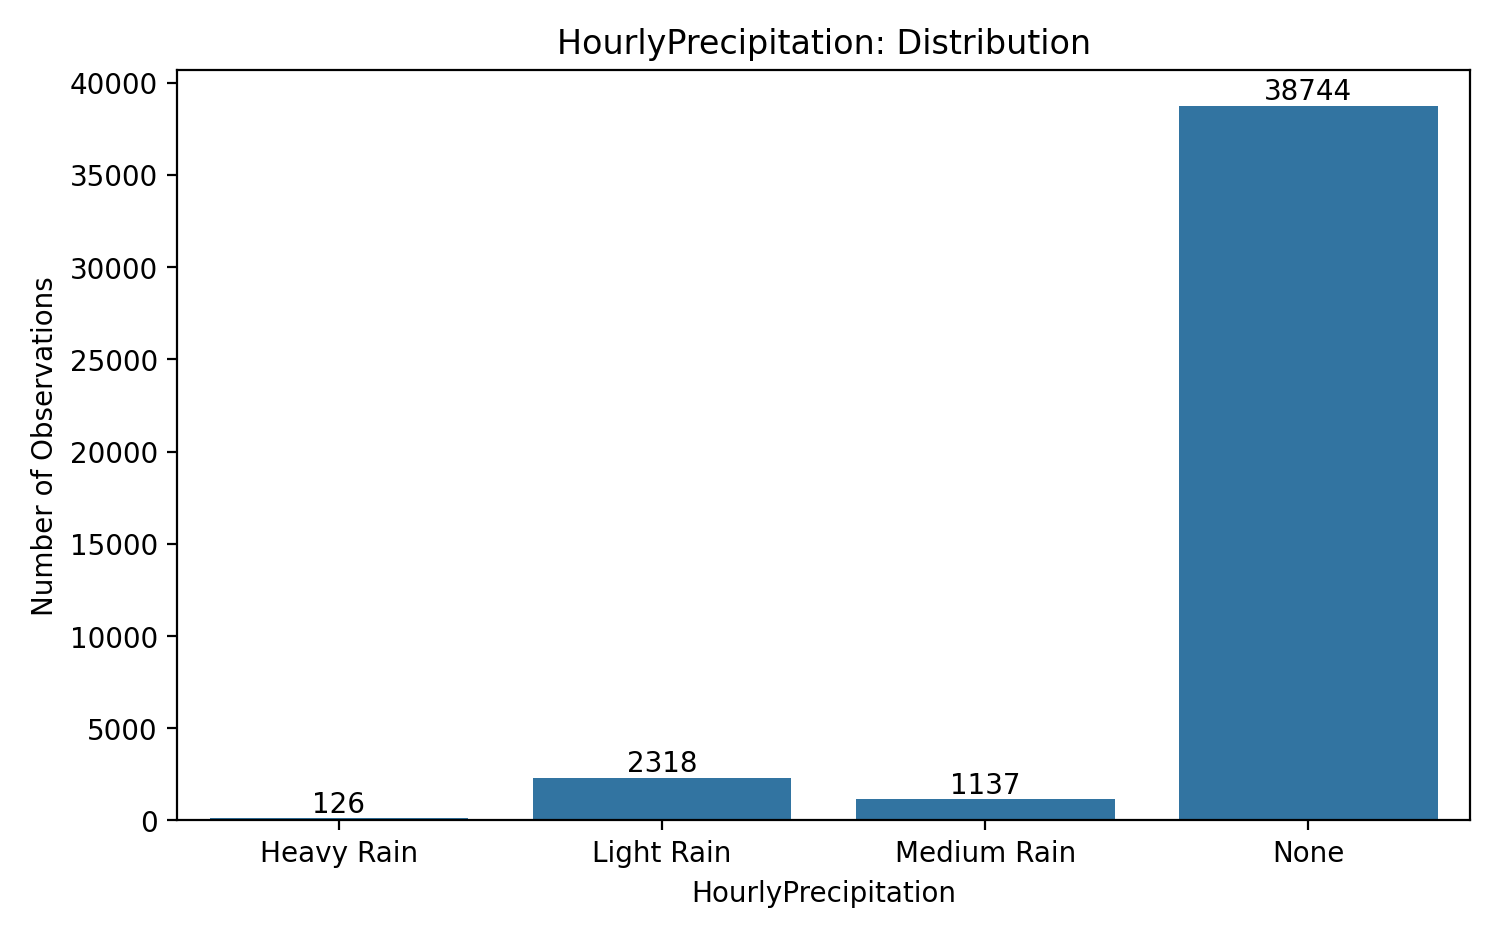

In [29]:
# check that all numerical variables have distribution plots
for variable in preliminary_dataset.columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Static Visuals/Distributions"
    filepath = r"{}/{}.png".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The distribution plot for {} is missing".format(variable))

# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in preliminary_dataset.columns])
filepath = r"{}/{}.png".format(directory, variable)

# Display the PNG file
Image(filename=filepath, width=750)

<br>

### Load Random Scatterplot

The following code conducts a similar check as above but for scatterplots between every variable included in the processing component of the pipeline and the dependent variable, *Energy Demand (MWH)*.

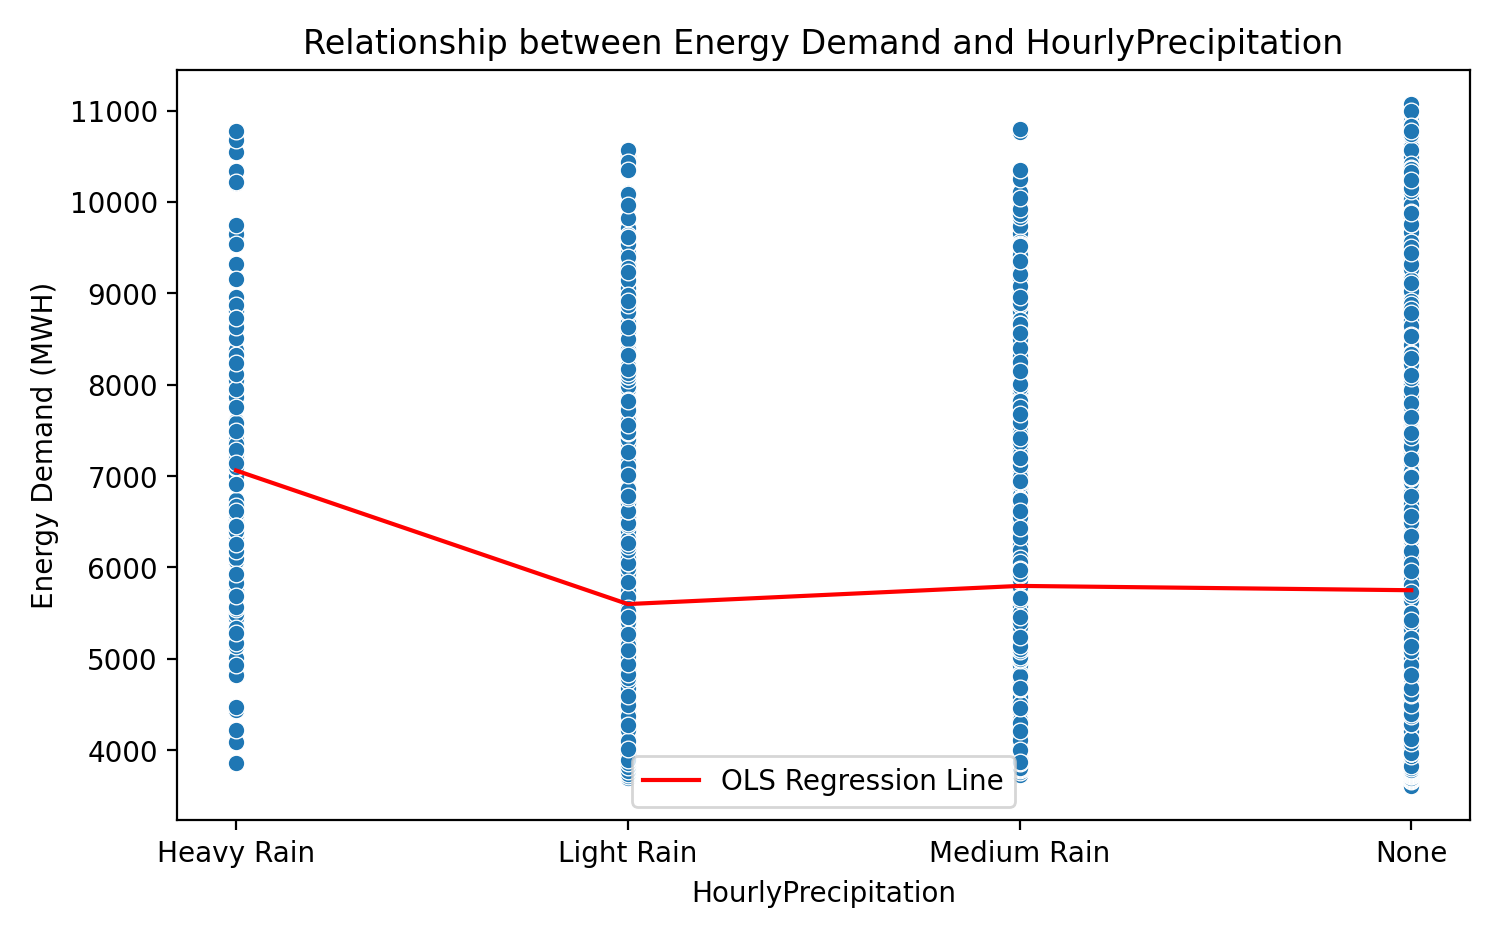

In [30]:
# check that all numerical variables have scatterplots
for variable in preliminary_dataset.columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Static Visuals/Scatterplots"
    filepath = r"{}/{}.png".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The scatterplot for {} is missing".format(variable))

# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in 
    preliminary_dataset.columns])
filepath = r"{}/{}.png".format(directory, variable)

# Display the PNG file
Image(filename=filepath, width=750)

<br>

### Load Random Time Series Decomposition Plot

Lastly, the following code conducts the same check but for time series decomposition plots for every numerical variable in the processed dataset. These variables correspond to the timer series variables.

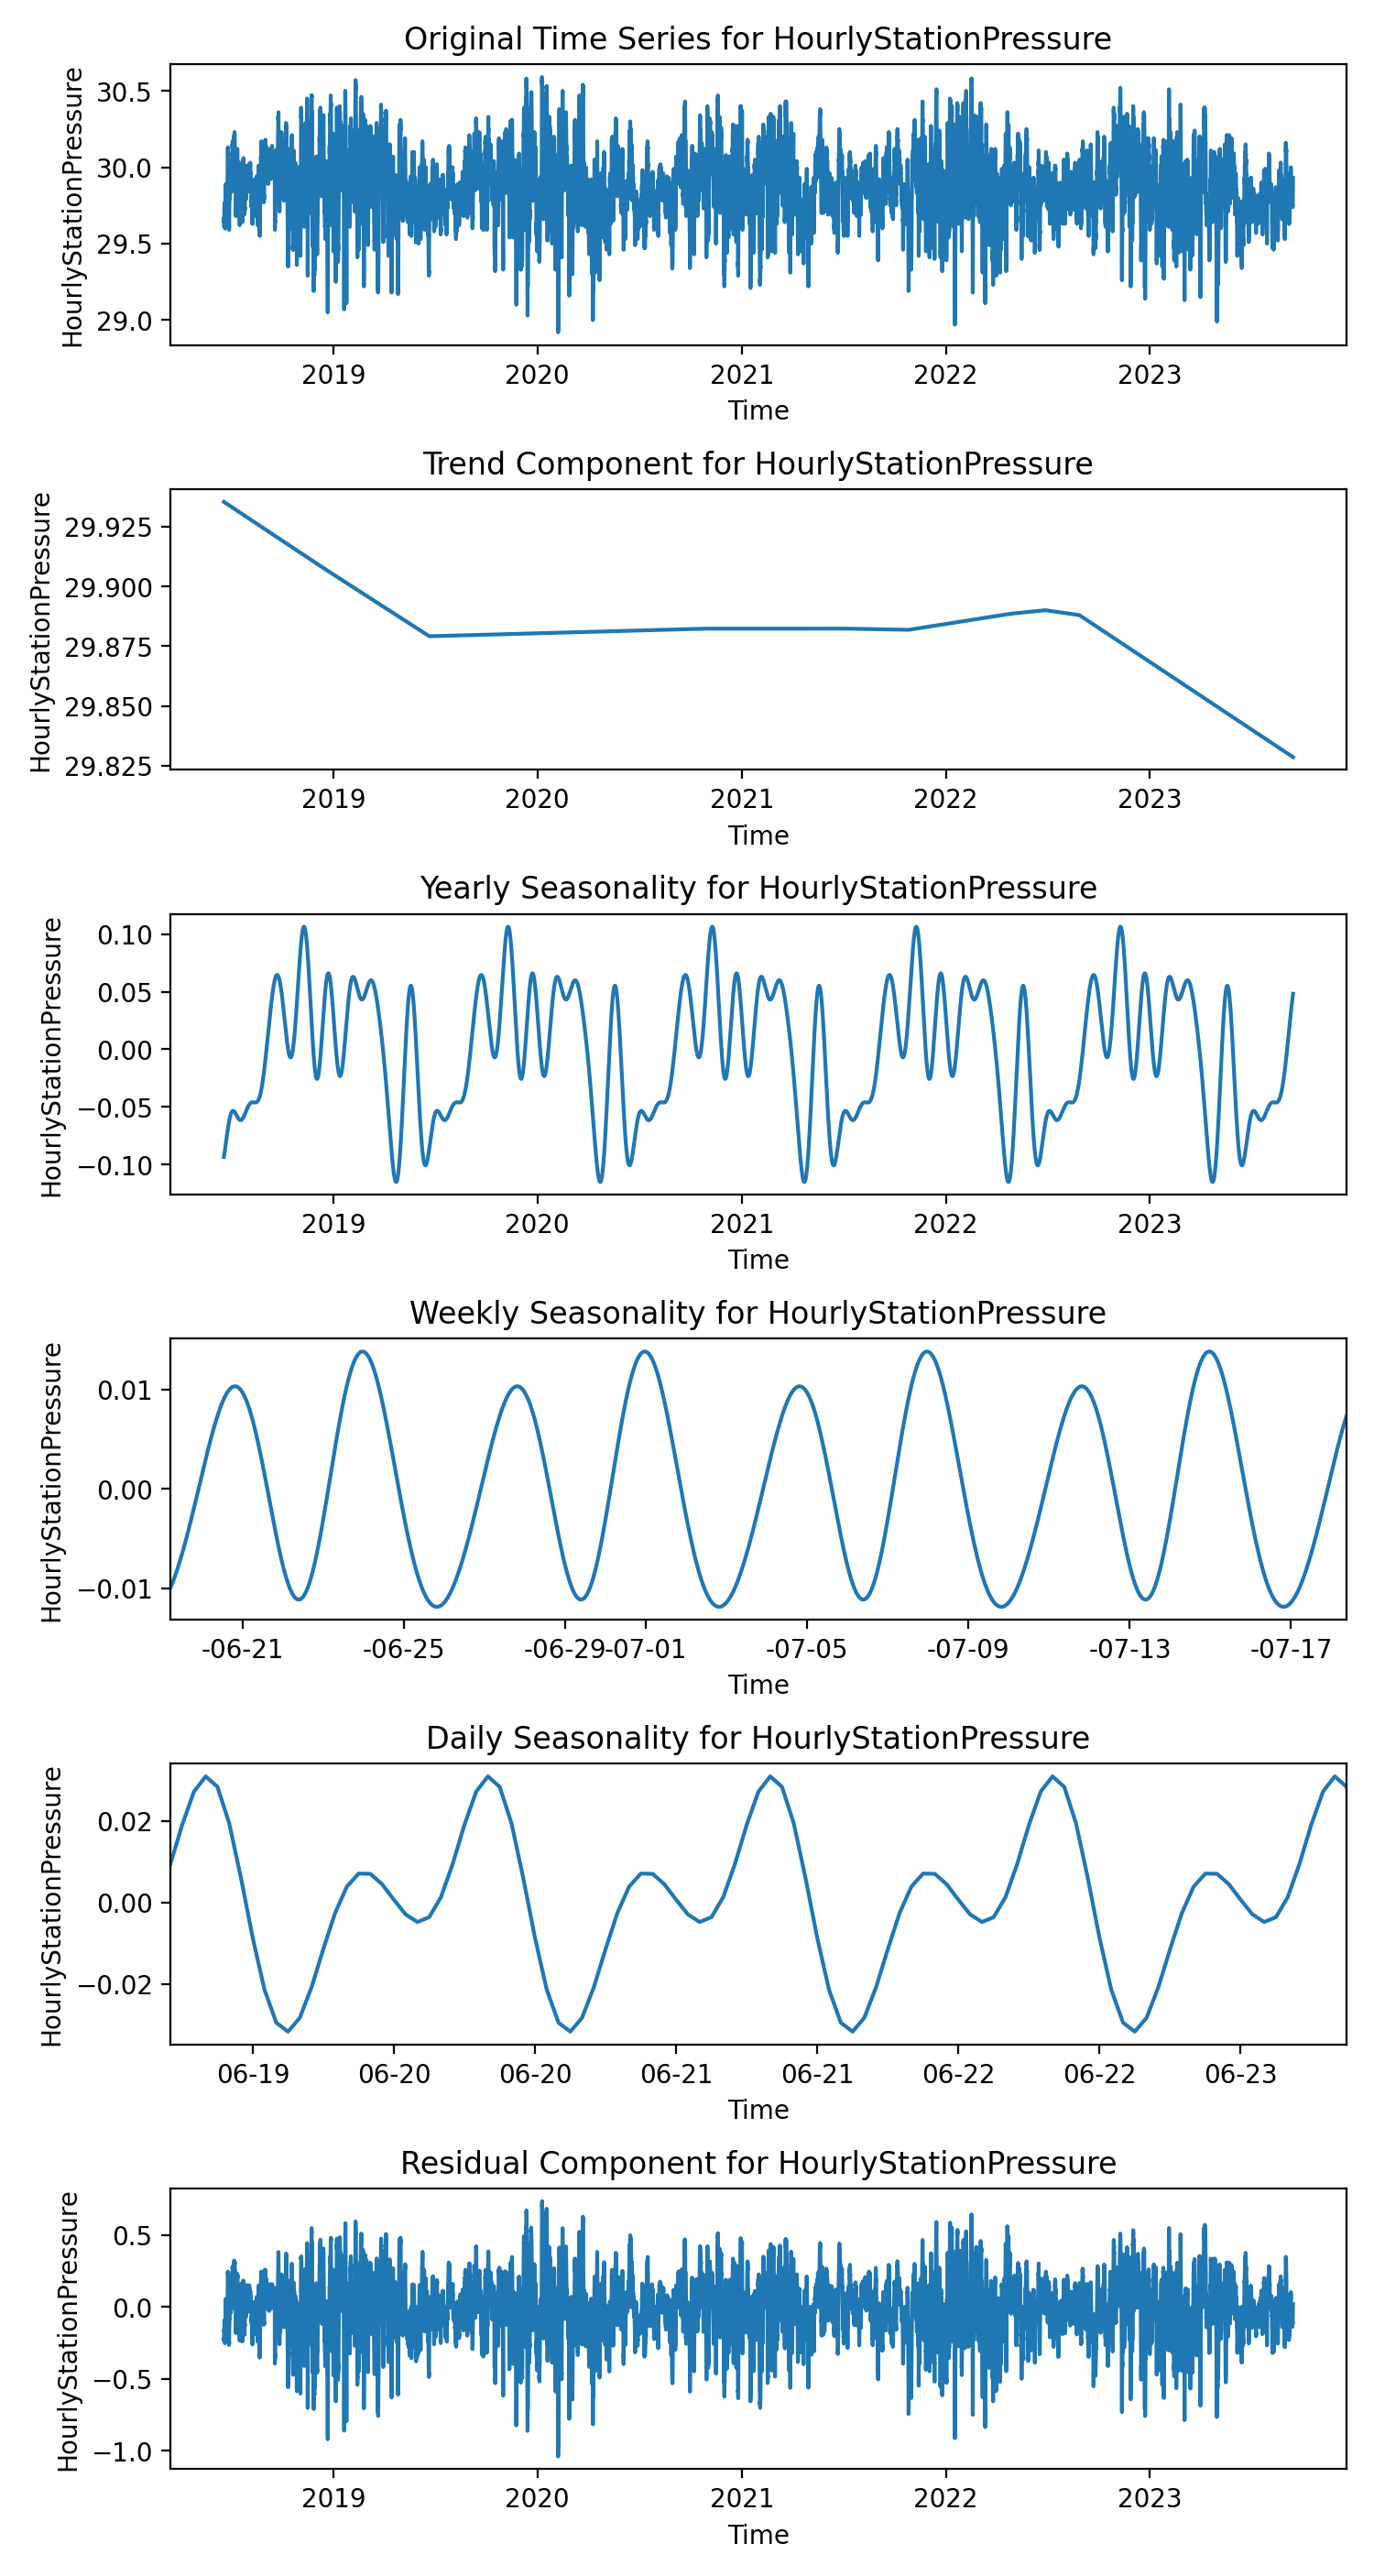

In [34]:
# check that all numerical variables have time series decomposition plots
for variable in clean_data.select_dtypes("number").columns:
    variable_filename = variable.replace(r"/", "-") # change variable name for file path
    directory = r"Saved/Static Visuals/Decompositions"
    filepath = r"{}/{}.png".format(directory, variable_filename)
    if not os.path.isfile(filepath): 
        raise AttributeError("The time series decomposition for {} is missing".format(variable))

# load random figure
variable = random.choice([variable.replace(r"/", "-") for variable in 
    clean_data.select_dtypes("number")])
filepath = r"{}/{}.png".format(directory, variable)

# Display the PNG file
Image(filename=filepath, width=750)

<br>

# Conclusion

If all of the cells in this notebook are able to run without error, then the data collection, processing, and predictive modeling components of the project are working correctly. While they are designed to work with several specific variables from the EIA, NOAA, and BLS, the *PreProcessingPipeline* and *Forecaster* classes should theoretically be applicable to any other dataset as well. One only need follow the steps outlined in this notebook to integrate the pipeline into their own project.